# 实战 Kaggle 比赛：房价预测

作为深度学习基础篇章的总结，我们将对本章内容学以致用。下面，让我们动手实战一个 Kaggle 比赛：房价预测。本节将提供未经调优的数据的预处理、模型的设计和超参数的选择。我们希望你通过动手操作、仔细观察实验现象、认真分析实验结果并不断调整方法，从而得到令自己满意的结果。

## Kaggle 比赛

Kaggle（网站地址：https://www.kaggle.com ）是一个著名的供机器学习爱好者交流的平台。图 3.7 展示了 Kaggle 网站首页。为了便于提交结果，你需要注册 Kaggle 账号。

![Kaggle网站首页。](../img/kaggle.png)

我们可以在房价预测比赛的网页上了解比赛信息和参赛者成绩，也可以下载数据集并提交自己的预测结果。该比赛的网页地址是

> https://www.kaggle.com/c/house-prices-advanced-regression-techniques


图 3.8 展示了房价预测比赛的网页信息。

![房价预测比赛的网页信息。比赛数据集可通过点击“Data”标签获取。](../img/house_pricing.png)

## 获取和读取数据集

比赛数据分为训练数据集和测试数据集。两个数据集都包括每栋房子的特征，例如街道类型、建造年份、房顶类型、地下室状况等特征值。这些特征值有连续的数字、离散的标签甚至是缺失值“na”。只有训练数据集包括了每栋房子的价格，也就是标签。我们可以访问比赛网页，点击图 3.8 中的“Data”标签，并下载这些数据集。

我们将通过使用`pandas`读入并处理数据。在导入本节需要的包前请确保已安装`pandas`，否则请参考下面代码注释。

In [1]:
# 如果没有安装 pandas，请反注释下面一行。
# !pip install pandas

%matplotlib inline
import gluonbook as gb
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
import numpy as np
import pandas as pd

解压后的数据位于`../data`目录，它包括两个 csv 文件。下面使用`pandas`读取这两个文件。

In [2]:
train_data = pd.read_csv('../data/kaggle_house_pred_train.csv')
test_data = pd.read_csv('../data/kaggle_house_pred_test.csv')

训练数据集包括 1460 个样本、80 个特征和 1 个标签。

In [3]:
train_data.shape

(1460, 81)

测试数据集包括 1459 个样本和 80 个特征。我们需要将测试数据集中每个样本的标签预测出来。

In [4]:
test_data.shape

(1459, 80)

让我们来查看前 4 个样本的前 4 个特征、后 2 个特征和标签（SalePrice）：

In [5]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


可以看到第一个特征是 Id，它能帮助模型记住每个训练样本，但难以推广到测试样本，所以我们不使用它来训练。我们将所有的训练和测试数据的 79 个特征按样本连结。

In [6]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## 预处理数据

我们对连续数值的特征做标准化（standardization）：设该特征在整个数据集上的均值为 $\mu$，标准差为 $\sigma$。那么，我们可以将该特征的每个值先减去 $\mu$ 再除以 $\sigma$ 得到标准化后的每个特征值。对于缺失的特征值，我们将其替换成该特征的均值。

In [7]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features = all_features.fillna(all_features.mean())

接下来将离散数值转成指示特征。举个例子，假设特征 MSZoning 里面有两个不同的离散值 RL 和 RM，那么这一步转换将去掉 MSZoning 特征，并新加两个特征 MSZoning\_RL 和 MSZoning\_RM，其值为 0 或 1。如果一个样本原来在 MSZoning 里的值为 RL，那么有 MSZoning\_RL=1 且 MSZoning\_RM=0。

In [8]:
# dummy_na=True 将缺失值也当做合法的特征值并为其创建指示特征。
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

可以看到这一步转换将特征数从 79 增加到了 331。

最后，通过`values`属性得到 NumPy 格式的数据，并转成 NDArray 方便后面的训练。

In [9]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

## 训练模型

我们使用一个基本的线性回归模型和平方损失函数来训练模型。

In [10]:
loss = gloss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

下面定义比赛用来评价模型的对数均方根误差。给定预测值 $\hat y_1, \ldots, \hat y_n$ 和对应的真实标签 $y_1,\ldots, y_n$，它的定义为

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log(y_i)-\log(\hat y_i)\right)^2}.$$

In [11]:
def log_rmse(net, train_features, train_labels):
    # 将小于 1 的值设成 1，使得取对数时数值更稳定。
    clipped_preds = nd.clip(net(train_features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), train_labels.log()).mean())
    return rmse.asscalar()

下面的训练函数跟本章中前几节的不同在于使用了 Adam 优化算法。相对之前使用的小批量随机梯度下降，它对学习率相对不那么敏感。我们将在之后的“优化算法”一章里详细介绍它。

In [12]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # 这里使用了 Adam 优化算法。
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## $K$ 折交叉验证

我们在[“模型选择、欠拟合和过拟合”](underfit-overfit.md)一节中介绍了 $K$ 折交叉验证。它将被用来选择模型设计并调节超参数。以下实现了一个函数，它返回第`i`折交叉验证时所需要的训练和验证数据。

In [13]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

在 $K$ 折交叉验证中我们训练 $K$ 次并返回训练和验证的平均误差。

In [14]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                  weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            gb.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                        range(1, num_epochs + 1), valid_ls,
                        ['train', 'valid'])
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

## 模型选择

我们使用一组未经调优的超参数并计算交叉验证误差。你可以改动这些超参数来尽可能减小平均测试误差。

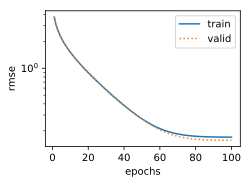

fold 0, train rmse: 0.169580, valid rmse: 0.156596


fold 1, train rmse: 0.162104, valid rmse: 0.189326


fold 2, train rmse: 0.163615, valid rmse: 0.167966


fold 3, train rmse: 0.168071, valid rmse: 0.154792


fold 4, train rmse: 0.162922, valid rmse: 0.182837
5-fold validation: avg train rmse: 0.165259, avg valid rmse: 0.170303


In [15]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
verbose_epoch = num_epochs - 2
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                         weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))

有时候你会发现一组参数的训练误差可以达到很低，但是在 $K$ 折交叉验证上的误差可能反而较高。这种现象很可能是由于过拟合造成的。因此，当训练误差降低时，我们要观察 $K$ 折交叉验证上的误差是否也相应降低。

## 预测并在 Kaggle 提交结果

下面定义预测函数。在预测之前，我们会使用完整的训练数据集来重新训练模型，并将预测结果存成提交所需要的格式。

In [16]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    gb.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

设计好模型并调好超参数之后，下一步就是对测试数据集上的房屋样本做价格预测。如果我们得到跟交叉验证时差不多的训练误差，那么这个结果很可能是理想的，可以在 Kaggle 上提交结果。

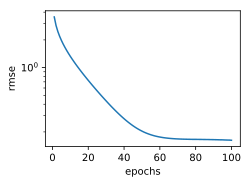

train rmse 0.162337


In [17]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

上述代码执行完之后会生成一个“submission.csv”文件。这个文件是符合 Kaggle 比赛要求的提交格式的。这时，我们可以在 Kaggle 上把我们预测得出的结果进行提交，并且查看与测试数据集上真实房价（标签）的误差。具体来说有以下几个步骤：你需要登录 Kaggle 网站，访问房价预测比赛网页，并点击右侧“Submit Predictions”或“Late Submission”按钮。然后，点击页面下方“Upload Submission File”图标所在的虚线框选择需要提交的预测结果文件。最后，点击页面最下方的“Make Submission”按钮就可以查看结果了。如图 3.9 所示。

![Kaggle预测房价比赛的预测结果提交页面。](../img/kaggle_submit2.png)


## 小结

* 我们通常需要对真实数据做预处理。
* 我们可以使用 $K$ 折交叉验证来选择模型并调节超参数。


## 练习

* 在 Kaggle 提交本教程的预测结果。观察一下，这个结果在 Kaggle 上能拿到什么样的分数？
* 对照 $K$ 折交叉验证结果，不断修改模型（例如添加隐藏层）和调参，你能提高 Kaggle 上的分数吗？
* 如果不使用本节中对连续数值特征的标准化处理，结果会有什么变化？
* 扫码直达讨论区，在社区交流方法和结果。你能发掘出其他更好的技巧吗？

## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/1039)

![](../img/qr_kaggle-house-price.svg)